# Obtención de datos

In [ ]:
import keras
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
#from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate, Activation, Dense, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard 
from tensorflow.keras.models import Sequential, Model
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [ ]:
# Download and unzip (2.2GB)
!wget http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
!tar -xzf testSetPlaces205_resize.tar.gz

--2022-06-01 15:13:05--  http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2341250899 (2.2G) [application/octet-stream]
Saving to: ‘testSetPlaces205_resize.tar.gz’

testSetPlaces205_re 100%[===================>]   2.18G  79.4MB/s    in 86s     

2022-06-01 15:14:31 (26.0 MB/s) - ‘testSetPlaces205_resize.tar.gz’ saved [2341250899/2341250899]



In [ ]:
# Move data into training and validation directories
import os
os.makedirs('images/train/class/', exist_ok=True) # 40,000 images
os.makedirs('images/val/class/', exist_ok=True)   #  1,000 images
for i, file in enumerate(os.listdir('testSet_resize')):
  if i < 1000: # first 1000 will be val
    os.rename('testSet_resize/' + file, 'images/val/class/' + file)
  else: # others will be val
    os.rename('testSet_resize/' + file, 'images/train/class/' + file)

In [ ]:
import glob
import numpy as np
from PIL import Image

filelist = glob.glob('/content/images/train/class/*.jpg')

In [ ]:
import glob
import numpy as np
from PIL import Image

filelist = glob.glob('/content/images/train/class/*.jpg')
filelist = filelist[:1000]
rgbs = [np.asarray(Image.open(fname)) for fname in filelist]
rgbs = [y/255 for y in rgbs if len(y.shape)==3]
rgbs = np.stack(rgbs, axis=0)

In [ ]:
filelist2 = filelist[1001:1200]
rgbs_test = [np.asarray(Image.open(fname)) for fname in filelist2]
rgbs_test = [y/255 for y in rgbs_test if len(y.shape)==3]
rgbs_test = np.stack(rgbs_test, axis=0)

In [ ]:
print(rgbs.shape)

(973, 256, 256, 3)


# Ver algunas imágenes

In [ ]:
import matplotlib.pyplot as plt

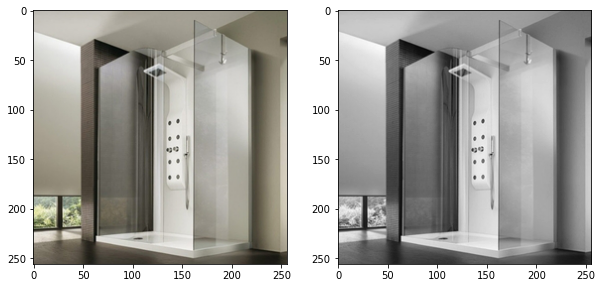

In [ ]:
figure,axis = plt.subplots(1,2,figsize=(10,10))
axis[0].imshow(rgbs[30])
axis[1].imshow(rgb2gray(rgbs[30]),cmap="gray")

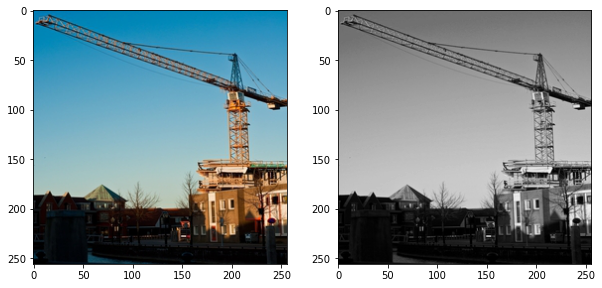

In [ ]:
figure,axis = plt.subplots(1,2,figsize=(10,10))
axis[0].imshow(rgbs[10])
axis[1].imshow(rgb2gray(rgbs[10]),cmap="gray")

# Modelo

In [ ]:
"""Cargar modelo inception """

inception = InceptionResNetV2(weights="imagenet", include_top=True)
graph = tf.compat.v1.get_default_graph()
inception.compile(run_eagerly=True)
inception.run_eagerly = True

"""Crear modelo con doble entrada, una imagen de 256x256 para el encoder-decoder
 y un vector de 1000 del Inception"""

embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(224, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(224, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

225222656/225209952 [==============================] - 1s 0us/step


In [ ]:
datagen = ImageDataGenerator(
        shear_range=0.4,
        zoom_range=0.4,
        rotation_range=40,
        horizontal_flip=True)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,
                              patience=10, min_lr=0.000001)

In [ ]:
from keras.callbacks import ModelCheckpoint 
from google.colab import drive
drive.mount('/content/gdrive/')
checkpoint = ModelCheckpoint(monitor='loss',filepath="/content/gdrive/My Drive/final_model.ckpt", verbose=1, save_best_only=True)

Mounted at /content/gdrive/


In [ ]:
from numpy.core.fromnumeric import mean
#Create embedding
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    #with graph.as_default():
        #inception.compile(run_eagerly=True)
    embed = inception.predict(grayscaled_rgb_resized)
    return embed

In [ ]:
def image_a_b_gen(batch_size):
    for batch in datagen.flow(rgbs, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        # print(np.unique(batch))
        # print(np.unique(lab_batch))
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        # print(np.unique(X_batch))
        Y_batch = lab_batch[:,:,:,1:] / 128
        # print(np.unique(Y_batch))
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.00003125)
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.load_weights('/content/gdrive/My Drive/final_model.ckpt')

In [ ]:
"""Compilar y entrenar"""

history=model.fit(image_a_b_gen(100),
                            steps_per_epoch=20, 
                            epochs=1000,
                            callbacks=[reduce_lr, checkpoint],
                            verbose=1)

Epoch 1/1000
20/20 [==============================] - ETA: 0s - loss: 0.0064
Epoch 1: loss improved from inf to 0.00642, saving model to /content/gdrive/My Drive/final_model.ckpt
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/final_model.ckpt/assets
20/20 [==============================] - 184s 9s/step - loss: 0.0064 - lr: 3.1250e-05
Epoch 2/1000
20/20 [==============================] - ETA: 0s - loss: 0.0063
Epoch 2: loss improved from 0.00642 to 0.00635, saving model to /content/gdrive/My Drive/final_model.ckpt
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/final_model.ckpt/assets
20/20 [==============================] - 153s 8s/step - loss: 0.0063 - lr: 3.1250e-05
Epoch 3/1000
20/20 [==============================] - ETA: 0s - loss: 0.0064
Epoch 3: loss did not improve from 0.00635
20/20 [==============================] - 155s 8s/step - loss: 0.0064 - lr: 3.1250e-05
Epoch 4/1000
20/20 [==============================] - ETA: 0s - loss: 0.0063
Epoch 4: loss i

# Probar el modelo con imagenes de test

In [ ]:
def testear(imagen):
  grayscaled_rgb = gray2rgb(rgb2gray(imagen))
  embed = create_inception_embedding(grayscaled_rgb)
  X = rgb2lab(imagen)[:,:,:,0] # antes hacíamos de entrada, no del grayscaled
  X = X.reshape(X.shape+(1,))

  #X_batch = lab_batch[:,:,:,0]
  #X_batch = X_batch.reshape(X_batch.shape+(1,))

  output = model.predict([X, embed]) * 128
  lab_output = np.zeros(shape=(256,256,3))
  lab_output[:,:,0] = rgb2lab(imagen)[:,:,:,0]
  lab_output[:,:,1:] = output
  figure,axis = plt.subplots(1,3,figsize=(20,20))
  axis[0].imshow(imagen[0]) # Original en RGB
  axis[1].imshow(rgb2gray(lab2rgb(lab_output)),cmap="gray") # Blanco y negro
  axis[2].imshow(lab2rgb(lab_output)) # Resultado

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 61 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


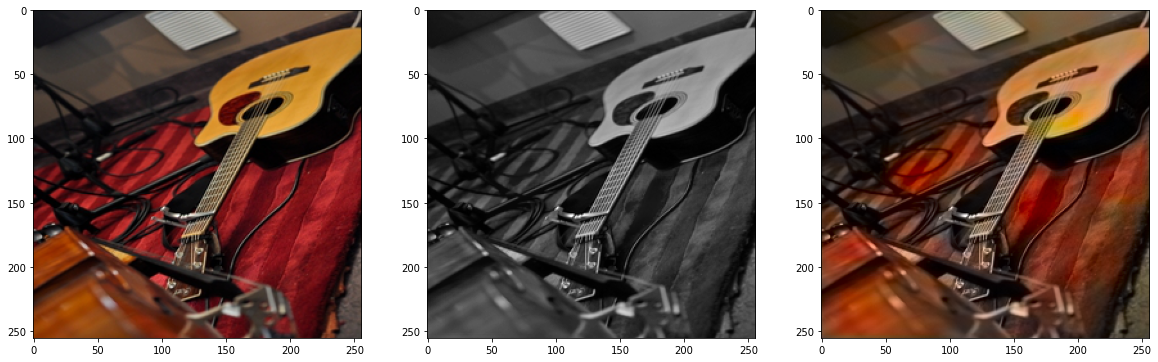

In [ ]:
testear(rgbs[8:9])

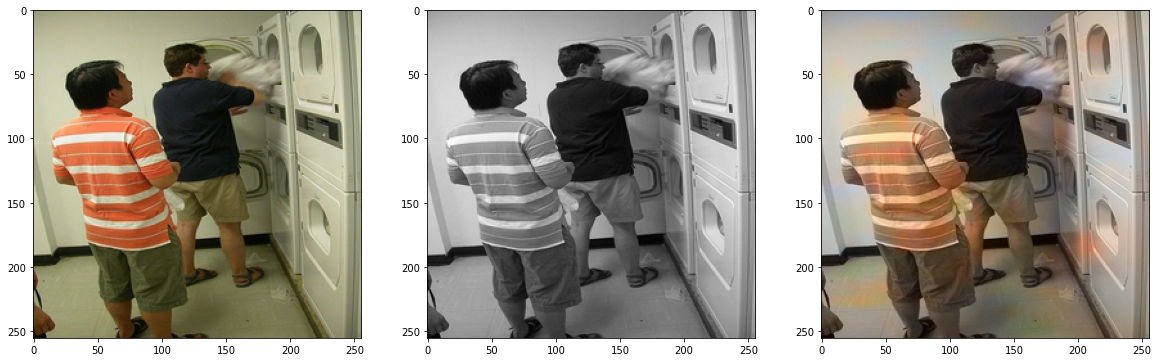

In [ ]:
testear(rgbs[147:148])

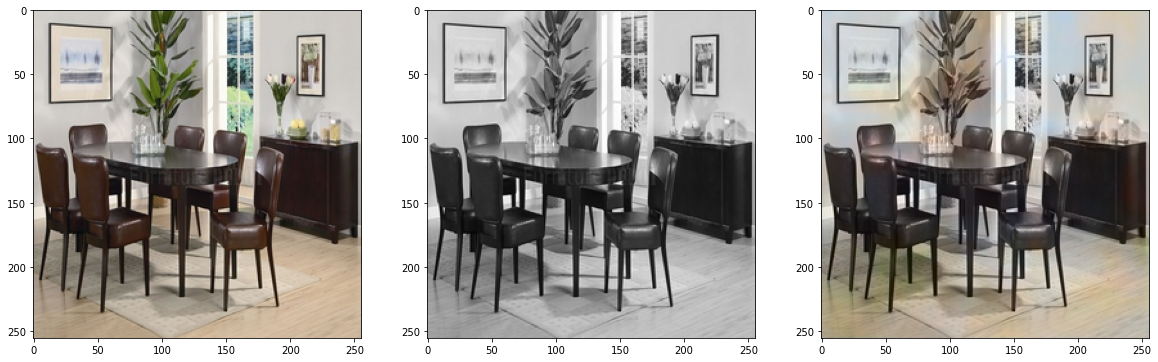

In [ ]:
testear(rgbs[156:157])

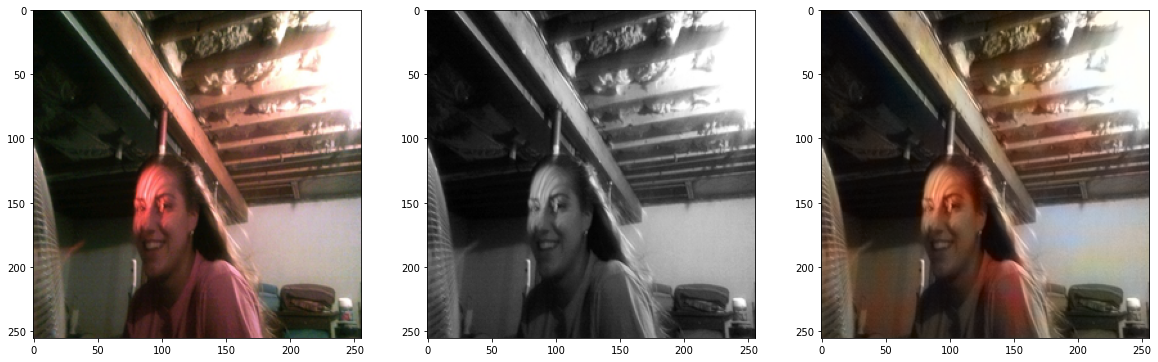

In [ ]:
testear(rgbs[153:154])

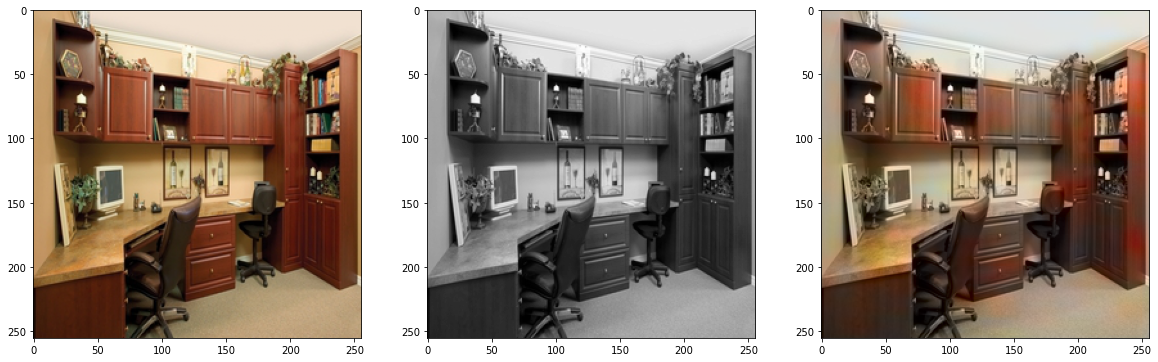

In [ ]:
testear(rgbs[151:152])